# Μηχανική Μάθηση σε δεδομένα από BCI

Γιώργος Παναγόπουλος (gpanagopoulos@iit.demokritos.gr)
[CRU](http://cru.iit.demokritos.gr/)

Η τελευταία έκδοση αυτού του tutorial βρίσκετε [εδώ](https://github.com/GiorgosPanagopoulos/Demokritos-SummerLab-2016).

### Εισαγωγή 

Η βελτιστοποίηση των διεπαφών εγκεφάλου μηχανής (Brain Computer Interfaces - BCI) αποτελεί πρόκληση για πολλούς τομείς της επστήμης ,όπως η ψηφιακή επεξεργασία σήματος, η νευροεπιστήμη, η ψυχολογία κτλ. 
Λόγω της διαφορετικότητας που χαραχτηρίζει κάθε ανθρώπινο εγκέφαλο, ένα BCI καλείτε είτε να προσαρμοστεί σε έναν άνθρωπο για να παράγει αξιόπιστα αποτελέσματα η να ενιχνεύσει και να εκμεταλευτεί πρότυπα εγκεφαλικής δραστηριότητας που ισχύουν σε όλους τους ανθρώπους. Εκεί ξεκινάει ο ρόλος της Μηχανικής Μάθησης.

Ο σκοπός της παρούσας άσκησης είναι αρχικά η εξοικείωση με EEG data και πως μπορούμε να τα χειριστούμε στην python, και μετέπειτα να εξετάσουμε μεθόδους μηχανικής μάθησης με σκοπό να αναγνωρίζουμε πότε ο άνθρωπος κλείνει το δεξί και πότε το αριστερό μάτι με βάση το EEG του.

### Φόρτωση και Οπτικοποίηση των Δεδομένων
Μπορούμε να οπτικοποίησουμε τις EEG χρονοσειρές που καταγράφηκαν κατα τα πειράματα, μέσα από plots.

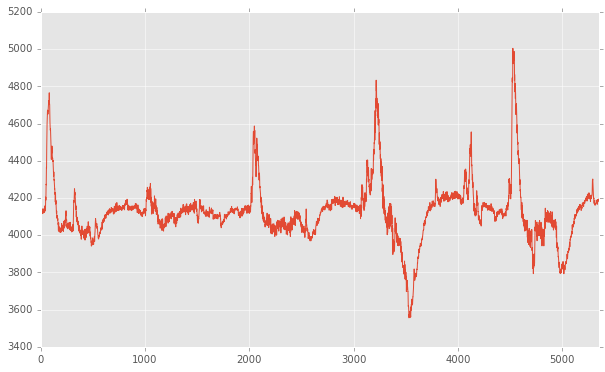

In [3]:
import os
os.chdir('C:\Users\Giwrgos\Desktop\Summer School')

import pandas as pd
import matplotlib
%matplotlib inline
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import matplotlib.pyplot as plt

raw = pd.read_csv("Sub1_Ses1_raw.csv")
ax = raw.ix[:,1].plot()

Επίσης μπορούμε να προσθέσουμε παραπάνω από ένα EEG κανάλι στο plot μας και να τραβήξουμε καθέτους που να μαρτυρούν πότε ο άνθρωπος έκλεισε το αριστερό μάτι και πότε το δεξί.

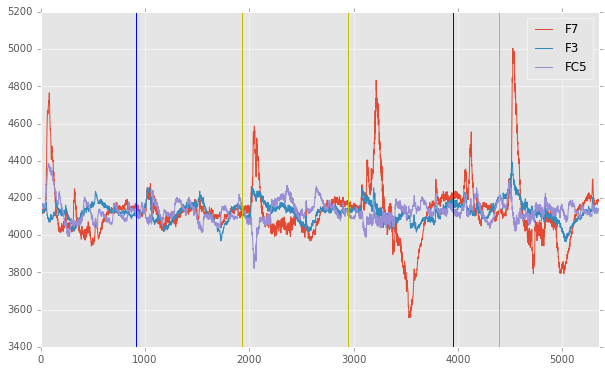

In [4]:
ax = raw.ix[:,(1,2,3)].plot()

events = pd.read_csv("Sub1_Ses1_events.csv",header = None )

left_events_idx = list(events.ix[events.ix[:,0]<0].index)
for e in left_events_idx:
    ax.axvline(x=e, color='b')

right_events_idx = list(events.ix[events.ix[:,0]>0].index)
for e in right_events_idx:
    ax.axvline(x=e, color='y')

### Feature Extraction

Για να πετύχει σωστή αναγνώριση προτύπων ένας αλγόριθμος χρησιμοποιεί δεδομένα που αντιστοιχούν στις περιπτώσεις που θέλουμε να "μάθει". Στην προκειμένη, οι εισόδοι μας στον αλγόριθμο είναι το EEG και η έξοδος είναι το αν ο άνθρωπος έκλεισε το αριστερό η το δεξί του μάτι. Συνεπώς πρέπει να εξάγουμε τα EEG σήματα από κάθε trial.

Είναι σημαντικό να παρατηρήσουμε πως το μήκος ανάμεσα σε δύο κινήσεις ματιών δεν είναι ίδιο. Αυτό συμβαίνει λογω του μεταβαλλόμενου ρυθμού δειγματοληψίας που έχει το EPOC+ και σημαίνει πως δεν μπορούμε να χρησιμοποιήσουμε το σήμα αυτό κάθε αυτό ως είσοδο στον αλγόριθμό μας, αφού τα παραδείγματα στα οποία βασίζετε ο αλγόριθμος πρέπει να έχουν ίδιο μέγεθος.

Αντί του σήματος σαν είσοδο στον αλγόριθμο, θα εισάγουμε αριθμούς κάποιες απλές μετρικές που θα εφαρμόσουμε στο σήμα, ώστε να αποτυπώσουμε όσο το δυνατόν καλύτερα την συμπεριφορά του.

* Μέση τιμή σήματος
* Διακύμανση
* Μέγιστη τιμή
* Ελάχιστη τιμή
* Εντροπία

In [5]:
import numpy as np

def extract_features(eeg):
    return [np.mean(eeg),np.std(eeg)]

def construct_dataset(raw,events):    
    events_idx = list(events.ix[events.ix[:,0]<>0].index)
    events_idx.append(max(raw.index))
    
    column_names = []
    for channel in raw:
        column_names.extend([
            channel+'_Mean',
            channel+'_Std'])
    
    data = pd.DataFrame(index=range(0,len(events_idx)-1),columns = column_names)

    for e in range(1,len(events_idx)):
        features = raw.ix[range(events_idx[e-1],events_idx[e]-1),:].apply(extract_features)
        data.ix[e-1,:] = [feature for channel in features for feature in channel]

    data['class'] = np.array(events.ix[events_idx[0:(len(events_idx)-1)]])

    return(data)

data = construct_dataset(raw,events)

Έτσι πετυχαίνουμε ένα είδος μείωσης των διαστάσεων και της πληροφορίας που εισάγουμε στον αλγόριθμο μηχανικής μάθησης, κάτι που είναι γενικά επιθυμητό. 

Θέλοντας να αξιοποιήσουμε όλα τα session από όλους τους συμμετέχοντες στο πείραμα, τα φορτώνουμε και τα επεξεργαζόμαστε με παρόμοιο τρόπο ώστε να καταλήξουμε σε ένα dataset που είναι η ένωση και των 5.

Αξίζει να σημειωθεί ότι λόγω της υψηλής διακύμανσης που συναντάται στην εγκεφαλική δραστηριότητα από άνθρωπο σε άνθρωπο, συνήθως δημιουργούνται εξατομικευμένα μοντέλα μηχανικής μάθησης για κάθε συμμετέχοντα. Λόγω απλότητας σε αυτό το tutorial, θα χρησιμοποιήσουμε μόνο ένα μοντέλο για όλους τους συμμετέχοντες. Η προσέγγιση αυτή ονομάζεται pooled analysis. 

In [6]:
for sub in range(1,2):
    for ses in range(2,5):
        raw = pd.read_csv('Sub'+str(sub)+'_Ses'+str(ses) +'_raw.csv')    
        events = pd.read_csv('Sub'+str(sub)+'_Ses'+str(ses)+'_events.csv',header = None )
        data = data.append(construct_dataset(raw,events),ignore_index=True)
    
data = (data - data.mean()) / (data.max() - data.min())
data['class']+=0.5

data.to_csv('bci_dataset.csv',index=False)

### Διερευνητική Ανάλυση

In [38]:
#------------Boxplotting
col = data.columns[0]  
data.boxplot(column=col,by='class')

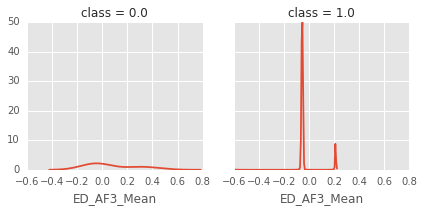

In [36]:
#------------Kernel densities
data_right = data.ix[data['class']>0.5,0:data.shape[1]-1]
data_left = data.ix[data['class']<0.5,0:data.shape[1]-1]

#data_right.ix[:,1].hist(color='r')
#data_left.ix[:,1].hist(color='b')

#data_left[col].plot(kind='kde',style='r--')
#data_right[col].plot(kind='kde',style='b--')
#plt.title(col+" PMF")

import seaborn as sns
g = sns.FacetGrid(data, col="class")
g.map(sns.kdeplot, col)

### Εφαρμογή Νευρωνικού Δικτύου

Για να φτιάξουμε το μοντέλο μηχανικής μάθησης που θα προβλέπει πότε κάποιος κλέινει το αριστερό η δεξί μάτι, θα χρησιμοποιήσουμε την βιβλιοθήκη [Keras](http://keras.io/), που χρησιμοποιείται συχνά για εφαρμογές deep learning.

Θα χρησιμοποιήσουμε default αρχιτεκτονικές ενός κρυμμένου επιπέδο, ενώ θα πειραματιστούμε με τον αριθμό κόμβων στον επίπεδο, ώστε να βρούμε τον βέλτιστο. Για να συγκρίνουμε την απόδοση του μοντέλου μας σε σχέση με τον αριθμό των κόμβων, θα τρέξουμε πειράματα και θα σχεδιάσουμε την απόδοση του κάθε μοντέλου, με βάση την ακρίβεια και το mean squared error του. 

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

loss_history = []
accuracy_history = []

n_features = data.shape[1]-1
n_rows = data.shape[0]
train = np.array(data.ix[:,0:n_features])
Y = np.array(data.ix[:,n_features])


for n_nodes in range(1,10):
    print('nodes used :',n_nodes)
    
    model = Sequential([
        Dense(n_nodes, input_dim = data.shape[1]-1,activation='tanh'),
        Dense(1,activation='tanh')
        ])
    
    model.compile(loss = 'mse', 
              optimizer = SGD(lr = 0.1),
              metrics = ['accuracy'])
         
    history = model.fit(train, Y,
                  nb_epoch = 30,
                  batch_size = n_rows)

    loss, accuracy = model.evaluate(train, Y)
    
    print('loss: ', loss)
    print('accuracy: ', accuracy)
    accuracy_history.append(accuracy)
    loss_history.append(loss)

Using Theano backend.
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.


('nodes used :', 1)
Epoch 1/30
24/24 [==============================] - 0s - loss: 0.5167 - acc: 0.5000
Epoch 2/30
24/24 [==============================] - 0s - loss: 0.4048 - acc: 0.5000
Epoch 3/30
24/24 [==============================] - 0s - loss: 0.3396 - acc: 0.5417
Epoch 4/30
24/24 [==============================] - 0s - loss: 0.3015 - acc: 0.5417
Epoch 5/30
24/24 [==============================] - 0s - loss: 0.2785 - acc: 0.5417
Epoch 6/30
24/24 [==============================] - 0s - loss: 0.2640 - acc: 0.5000
Epoch 7/30
24/24 [==============================] - 0s - loss: 0.2544 - acc: 0.5417
Epoch 8/30
24/24 [==============================] - 0s - loss: 0.2478 - acc: 0.5417
Epoch 9/30
24/24 [==============================] - 0s - loss: 0.2429 - acc: 0.5417
Epoch 10/30
24/24 [==============================] - 0s - loss: 0.2391 - acc: 0.5417
Epoch 11/30
24/24 [==============================] - 0s - loss: 0.2361 - acc: 0.5417
Epoch 12/30
24/24 [==============================] - 0

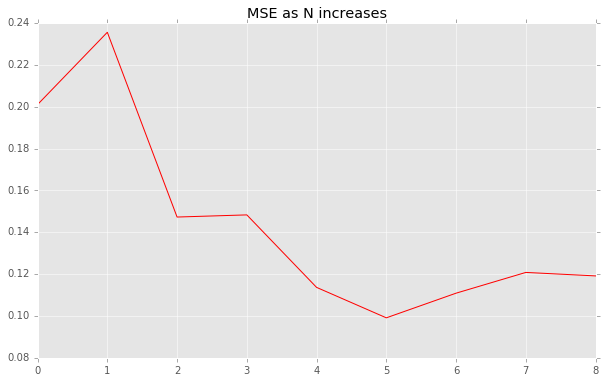

In [10]:
plt.plot(loss_history,color='r')
plt.title('MSE as N increases')

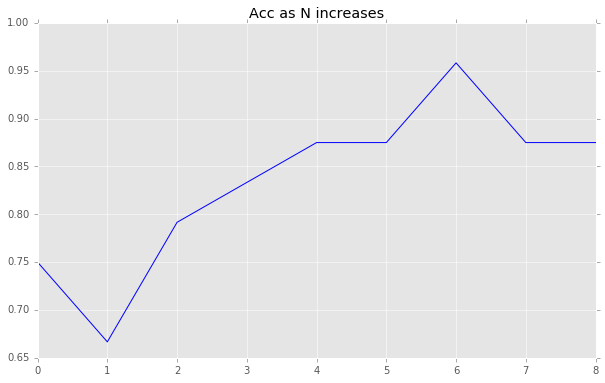

In [11]:
plt.plot(accuracy_history,color='b')
plt.title('Acc as N increases')

### Αξιολόγηση μοντέλου

In [12]:
from sklearn.cross_validation import train_test_split

train, test = train_test_split(data, test_size = 0.25)
train = np.array(train)
test = np.array(test)

model.fit(train[:,0:n_features],
          train[:,n_features],
          nb_epoch=30,
          batch_size = n_rows)

score = model.evaluate( test[:,0:n_features] , test[:,n_features] , batch_size=n_rows)
print(score)

Epoch 1/30
18/18 [==============================] - 0s - loss: 0.1101 - acc: 0.8889
Epoch 2/30
18/18 [==============================] - 0s - loss: 0.1059 - acc: 0.8889
Epoch 3/30
18/18 [==============================] - 0s - loss: 0.1024 - acc: 0.8889
Epoch 4/30
18/18 [==============================] - 0s - loss: 0.0992 - acc: 0.8889
Epoch 5/30
18/18 [==============================] - 0s - loss: 0.0963 - acc: 0.8889
Epoch 6/30
18/18 [==============================] - 0s - loss: 0.0936 - acc: 0.8889
Epoch 7/30
18/18 [==============================] - 0s - loss: 0.0911 - acc: 0.8889
Epoch 8/30
18/18 [==============================] - 0s - loss: 0.0887 - acc: 0.8889
Epoch 9/30
18/18 [==============================] - 0s - loss: 0.0864 - acc: 0.8889
Epoch 10/30
18/18 [==============================] - 0s - loss: 0.0842 - acc: 0.8889
Epoch 11/30
18/18 [==============================] - 0s - loss: 0.0821 - acc: 0.8889
Epoch 12/30
18/18 [==============================] - 0s - loss: 0.0801 - a

Τέλος, φορτώνουμε τα πραγματικά test data, για τα οποία δεν έχουμε το Y, και χρησιμοποιούμε το μοντέλο μας για να προβλέψουμε σε τι κλάση αντιστοιχεί το κάθε sample του μοντέλου.

In [ ]:
events = pd.read_csv("Test_events.csv",header = None )
raw = pd.read_csv("Test_raw.csv")
test_data = construct_dataset(raw,events)

pd.DataFrame(model.predict_classes(test_data)).to_csv('bci_predictions.csv',index=False)